In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
import pandas as pd
import zipfile
import os

# Define paths to your zip files
normal_zip_path = '../data/pure normal/Normal.zip'
mixed_zip_path = '../data/mixed/Mixed.zip'

def load_sessions_from_zip(zip_path):
    """Extracts and loads all CSV files from a zip archive into a dictionary of DataFrames."""
    sessions = {}
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            for filename in z.namelist():
                if filename.endswith('.csv'):
                    with z.open(filename) as f:
                        df = pd.read_csv(f)
                        sessions[filename] = df
        return sessions
    except FileNotFoundError:
        print(f"File not found: {zip_path}")
        return {}

# Load the datasets as dictionaries of sessions
print("Loading Normal (Training) Sessions...")
train_sessions = load_sessions_from_zip(normal_zip_path)

print("Loading Mixed (Testing) Sessions...")
test_sessions = load_sessions_from_zip(mixed_zip_path)

# Display info
print(f"Loaded {len(train_sessions)} training sessions.")
print(f"Loaded {len(test_sessions)} testing sessions.")

Loading Normal (Training) Sessions...
Loading Mixed (Testing) Sessions...
Loaded 3 training sessions.
Loaded 5 testing sessions.


# Preprocessing

In [4]:
def preprocess_session_data(df):
    """Preprocess session data with mouse/keyboard event separation"""
    print(f"Initial data shape: {df.shape}")
    
    # Select available columns
    useful_columns = ['Time (seconds)', 'Event Type', 'X Coordinate', 'Y Coordinate', 'Action', 'Is Cheating']
    available_columns = [col for col in useful_columns if col in df.columns]
    df_clean = df[available_columns].copy()
    
    # Remove session summary overhead
    summary_idx = df_clean[df_clean.iloc[:, 0] == "SESSION SUMMARY"].index
    if len(summary_idx) > 0:
        df_clean = df_clean.iloc[:summary_idx[0]]
    
    # Convert time to numeric and drop invalid rows
    df_clean["Time (seconds)"] = pd.to_numeric(df_clean["Time (seconds)"], errors='coerce')
    df_clean = df_clean.dropna(subset=["Time (seconds)"])
    
    # Categorize events
    mouse_events = ['mousemove', 'click']
    keyboard_events = ['keydown', 'copy', 'paste']
    action_events = ['tab-switch']
    
    df_clean['is_mouse_event'] = df_clean['Event Type'].isin(mouse_events)
    df_clean['is_keyboard_event'] = df_clean['Event Type'].isin(keyboard_events)
    df_clean['is_action_event'] = df_clean['Event Type'].isin(action_events)
    
    # Handle coordinates (forward fill for mouse events)
    if 'X Coordinate' in df_clean.columns and 'Y Coordinate' in df_clean.columns:
        df_clean['X Coordinate'] = df_clean['X Coordinate'].ffill()
        df_clean['Y Coordinate'] = df_clean['Y Coordinate'].ffill()
        df_clean = df_clean.dropna(subset=['X Coordinate', 'Y Coordinate'])
    
    # Create action features
    if 'Action' in df_clean.columns:
        df_clean["is_copy"] = ((df_clean["Action"] == "copy") | (df_clean["Event Type"] == "copy")).astype(int)
        df_clean["is_paste"] = ((df_clean["Action"] == "paste") | (df_clean["Event Type"] == "paste")).astype(int)
        df_clean["is_blur"] = (df_clean["Action"] == "blur").astype(int)
        df_clean["is_focus"] = (df_clean["Action"] == "focus").astype(int)
    else:
        for action in ["is_copy", "is_paste", "is_blur", "is_focus"]:
            df_clean[action] = 0
    
    df_clean["is_tab_switch"] = (df_clean["Event Type"] == "tab-switch").astype(int)
    
    # Handle cheating column
    if 'Is Cheating' in df_clean.columns:
        df_clean["Is Cheating"] = df_clean["Is Cheating"].astype(bool)
    else:
        df_clean["Is Cheating"] = False
    
    print(f"Final shape: {df_clean.shape}")
    return df_clean

In [5]:
def safe_agg(series, func):
    """Safely aggregate series with NaN handling"""
    if len(series) == 0:
        return 0
    clean_series = series.dropna()
    return func(clean_series) if len(clean_series) > 0 else 0

# Feature extraction

In [6]:
def extract_mouse_features(mouse_chunk):
    """Extract comprehensive mouse movement features"""
    if len(mouse_chunk) < 2:
        return {f'mouse_{feat}': 0 for feat in [
            'path_length', 'straightness', 'velocity_mean', 'velocity_std', 'velocity_max',
            'acceleration_mean', 'acceleration_std', 'acceleration_max', 'jerk_mean', 'jerk_std',
            'direction_changes', 'click_count', 'idle_time_ratio', 'angular_velocity_mean',
            'angular_velocity_std', 'angular_velocity_min', 'angular_velocity_max',
            'curvature_mean', 'curvature_std', 'curvature_min', 'curvature_max',
            'direction_class', 'sum_of_angles', 'largest_deviation', 'sharp_angles'
        ]}
    
    mouse_chunk = mouse_chunk.sort_values("Time (seconds)").copy()
    
    # Calculate motion derivatives
    mouse_chunk["dx"] = mouse_chunk["X Coordinate"].diff()
    mouse_chunk["dy"] = mouse_chunk["Y Coordinate"].diff()
    # Robust dt: clip to minimum 1ms to avoid explosion
    mouse_chunk["dt"] = mouse_chunk["Time (seconds)"].diff().fillna(1e-3).clip(lower=1e-3)
    
    # Velocities and accelerations
    mouse_chunk["vx"] = mouse_chunk["dx"] / mouse_chunk["dt"]
    mouse_chunk["vy"] = mouse_chunk["dy"] / mouse_chunk["dt"]
    mouse_chunk["velocity"] = np.sqrt(mouse_chunk["vx"]**2 + mouse_chunk["vy"]**2)
    
    mouse_chunk["ax"] = mouse_chunk["vx"].diff() / mouse_chunk["dt"]
    mouse_chunk["ay"] = mouse_chunk["vy"].diff() / mouse_chunk["dt"]
    mouse_chunk["acceleration"] = np.sqrt(mouse_chunk["ax"]**2 + mouse_chunk["ay"]**2)
    
    mouse_chunk["jerk"] = mouse_chunk["acceleration"].diff() / mouse_chunk["dt"]
    
    # Angular calculations
    mouse_chunk["angle"] = np.arctan2(mouse_chunk["dy"], mouse_chunk["dx"])
    mouse_chunk["angular_velocity"] = mouse_chunk["angle"].diff() / mouse_chunk["dt"]
    
    # Curvature
    velocity_mag_cubed = mouse_chunk["velocity"]**3
    cross_product = mouse_chunk["vx"] * mouse_chunk["ay"] - mouse_chunk["vy"] * mouse_chunk["ax"]
    # Avoid division by zero with small epsilon
    mouse_chunk["curvature"] = np.abs(cross_product) / (velocity_mag_cubed + 1e-6)
    
    # Path metrics
    distances = np.sqrt(mouse_chunk["dx"]**2 + mouse_chunk["dy"]**2)
    path_length = distances.sum()
    
    start_x, start_y = mouse_chunk.iloc[0][['X Coordinate', 'Y Coordinate']]
    end_x, end_y = mouse_chunk.iloc[-1][['X Coordinate', 'Y Coordinate']]
    end_to_end_dist = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    
    straightness = end_to_end_dist / path_length if path_length > 0 else 0
    direction_changes = (np.abs(mouse_chunk["angle"].diff()) > np.pi/4).sum()
    click_count = (mouse_chunk["Event Type"] == "click").sum()
    
    # Idle time analysis
    velocity_clean = mouse_chunk["velocity"].dropna()
    if len(velocity_clean) > 0:
        low_velocity_threshold = np.percentile(velocity_clean, 10)
        idle_time = mouse_chunk[mouse_chunk["velocity"] <= low_velocity_threshold]["dt"].sum()
        total_time = mouse_chunk["dt"].sum()
        idle_ratio = idle_time / total_time if total_time > 0 else 0
    else:
        idle_ratio = 0
    
    # Direction classification
    if end_to_end_dist > 0:
        direction_angle = np.arctan2(end_y - start_y, end_x - start_x)
        direction_degrees = (np.degrees(direction_angle) + 360) % 360
        direction_class = min(int(direction_degrees // 45) + 1, 8)
    else:
        direction_class = 0
    
    # Largest deviation from straight line (Vectorized)
    if len(mouse_chunk) >= 3 and end_to_end_dist > 0:
        x1, y1, x2, y2 = start_x, start_y, end_x, end_y
        
        # Points
        x0 = mouse_chunk["X Coordinate"].values
        y0 = mouse_chunk["Y Coordinate"].values
        
        # Distance from point to line defined by p1 and p2
        numerator = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        line_length = end_to_end_dist
        
        deviations = numerator / line_length
        largest_deviation = np.max(deviations)
    else:
        largest_deviation = 0
    
    # Sharp angles
    angle_changes = np.abs(mouse_chunk["angle"].diff())
    sharp_angles = (angle_changes > 0.0005).sum()
    sum_of_angles = safe_agg(np.abs(mouse_chunk["angle"].diff()), np.sum)
    
    return {
        'mouse_path_length': path_length,
        'mouse_straightness': straightness,
        'mouse_velocity_mean': safe_agg(mouse_chunk["velocity"], np.mean),
        'mouse_velocity_std': safe_agg(mouse_chunk["velocity"], np.std),
        'mouse_velocity_max': safe_agg(mouse_chunk["velocity"], np.max),
        'mouse_acceleration_mean': safe_agg(mouse_chunk["acceleration"], np.mean),
        'mouse_acceleration_std': safe_agg(mouse_chunk["acceleration"], np.std),
        'mouse_acceleration_max': safe_agg(mouse_chunk["acceleration"], np.max),
        'mouse_jerk_mean': safe_agg(mouse_chunk["jerk"], np.mean),
        'mouse_jerk_std': safe_agg(mouse_chunk["jerk"], np.std),
        'mouse_direction_changes': direction_changes,
        'mouse_click_count': click_count,
        'mouse_idle_time_ratio': idle_ratio,
        'mouse_angular_velocity_mean': safe_agg(mouse_chunk["angular_velocity"], np.mean),
        'mouse_angular_velocity_std': safe_agg(mouse_chunk["angular_velocity"], np.std),
        'mouse_angular_velocity_min': safe_agg(mouse_chunk["angular_velocity"], np.min),
        'mouse_angular_velocity_max': safe_agg(mouse_chunk["angular_velocity"], np.max),
        'mouse_curvature_mean': safe_agg(mouse_chunk["curvature"], np.mean),
        'mouse_curvature_std': safe_agg(mouse_chunk["curvature"], np.std),
        'mouse_curvature_min': safe_agg(mouse_chunk["curvature"], np.min),
        'mouse_curvature_max': safe_agg(mouse_chunk["curvature"], np.max),
        'mouse_direction_class': direction_class,
        'mouse_sum_of_angles': sum_of_angles,
        'mouse_largest_deviation': largest_deviation,
        'mouse_sharp_angles': sharp_angles,
    }

In [7]:
def extract_features_from_chunk(chunk, cheating_threshold=0.5):
    """Extract all features from a data chunk"""
    # Determine if chunk is cheating
    if 'Is Cheating' in chunk.columns:
        cheating_ratio = chunk["Is Cheating"].mean()
        chunk_is_cheating = cheating_ratio >= cheating_threshold
    else:
        chunk_is_cheating = False
    
    # Calculate elapsed time
    elapsed_time = max(chunk.iloc[-1]["Time (seconds)"] - chunk.iloc[0]["Time (seconds)"], 1e-6)
    
    # Separate event types
    mouse_chunk = chunk[chunk["is_mouse_event"]].copy()
    keyboard_chunk = chunk[chunk["is_keyboard_event"]].copy()
    
    # Extract features
    mouse_features = extract_mouse_features(mouse_chunk)
    keyboard_features = extract_keyboard_features(keyboard_chunk)
    
    # Basic features
    basic_features = {
        "elapsed_time": elapsed_time,
        "copy_events": chunk["is_copy"].sum(),
        "paste_events": chunk["is_paste"].sum(),
        "blur_events": chunk["is_blur"].sum(),
        "focus_events": chunk["is_focus"].sum(),
        "tab_switch_events": chunk["is_tab_switch"].sum(),
        "is_cheating": chunk_is_cheating
    }
    
    return {**basic_features, **mouse_features, **keyboard_features}

In [8]:
def extract_keyboard_features(keyboard_chunk):
    """Extract keyboard typing behavior features"""
    if len(keyboard_chunk) == 0:
        return {
            'keyboard_typing_rate': 0,
            'keyboard_burst_count': 0,
            'keyboard_pause_count': 0,
        }
    
    keyboard_chunk = keyboard_chunk.sort_values("Time (seconds)")
    
    # Typing rate
    if len(keyboard_chunk) >= 2:
        time_span = keyboard_chunk.iloc[-1]["Time (seconds)"] - keyboard_chunk.iloc[0]["Time (seconds)"]
        typing_rate = len(keyboard_chunk) / time_span if time_span > 0 else 0
        
        # Burst and pause analysis
        time_diffs = keyboard_chunk["Time (seconds)"].diff().dropna()
        burst_events = (time_diffs < 0.2).sum()  # <0.2s = burst
        pause_events = (time_diffs > 1.0).sum()  # >1s = pause
    else:
        typing_rate = burst_events = pause_events = 0
    
    return {
        'keyboard_typing_rate': typing_rate,
        'keyboard_burst_count': burst_events,
        'keyboard_pause_count': pause_events,
    }

In [9]:
def extract_features_from_session(df_session, chunk_size=5, step_size=1, cheating_threshold=0.5, session_name=""):
    """Extract features from a complete session using sliding windows"""
    print(f"\n=== Processing session: {session_name} ===")
    
    if len(df_session) < chunk_size:
        print(f"Warning: Insufficient data ({len(df_session)} rows, need {chunk_size})")
        return pd.DataFrame()
    
    chunks = []
    for start in range(0, len(df_session) - chunk_size + 1, step_size):
        chunk = df_session.iloc[start:start+chunk_size]
        features = extract_features_from_chunk(chunk, cheating_threshold)
        chunks.append(features)
    
    features_df = pd.DataFrame(chunks)
    
    if not features_df.empty:
        features_df['session_name'] = session_name
        
    cheating_count = features_df['is_cheating'].sum()
    print(f"Extracted {len(chunks)} chunks, {cheating_count} cheating ({cheating_count/len(chunks)*100:.1f}%)")
    
    return features_df

# File loaders

In [10]:
def process_single_file(file_path, chunk_size=5, step_size=1, cheating_threshold=0.5):
    """
    Process a single session file
    """
    session_name = Path(file_path).stem
    print(f"\n{'='*50}")
    print(f"Processing: {session_name}")
    print(f"{'='*50}")
    
    try:
        # Read CSV
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} rows from {file_path}")
        
        # Preprocess
        df_clean = preprocess_session_data(df)
        
        if df_clean.empty:
            print("No data after preprocessing")
            return pd.DataFrame()
        
        # Extract features
        features_df = extract_features_from_session(
            df_clean, 
            chunk_size=chunk_size, 
            step_size=step_size, 
            cheating_threshold=cheating_threshold,
            session_name=session_name
        )
        
        return features_df
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.DataFrame()



In [11]:
def process_multiple_files(file_paths, chunk_size=5, step_size=1, cheating_threshold=0.5):
    """
    Process multiple session files and combine them
    """
    # Handle different input types
    if isinstance(file_paths, str):
        if '*' in file_paths or '?' in file_paths:
            file_paths = glob.glob(file_paths)
        elif os.path.isdir(file_paths):
            file_paths = glob.glob(os.path.join(file_paths, "*.csv"))
        else:
            file_paths = [file_paths]
    
    print(f"Found {len(file_paths)} files to process")
    
    all_features = []
    successful_sessions = 0
    
    for file_path in file_paths:
        session_features = process_single_file(
            file_path, 
            chunk_size=chunk_size, 
            step_size=step_size, 
            cheating_threshold=cheating_threshold
        )
        
        if not session_features.empty:
            all_features.append(session_features)
            successful_sessions += 1
        else:
            print(f"Failed to process: {file_path}")
    
    if all_features:
        combined_df = pd.concat(all_features, ignore_index=True)
        
        print(f"\n{'='*60}")
        print("FINAL SUMMARY")
        print(f"{'='*60}")
        print(f"Successfully processed: {successful_sessions}/{len(file_paths)} sessions")
        print(f"Total chunks: {len(combined_df)}")
        print(f"Cheating chunks: {combined_df['is_cheating'].sum()}")
        print(f"Normal chunks: {(~combined_df['is_cheating']).sum()}")
        print(f"Features extracted: {len(combined_df.columns)-2}")  # -2 for session_name and is_cheating
        
        # Feature breakdown
        mouse_features = [col for col in combined_df.columns if col.startswith('mouse_')]
        keyboard_features = [col for col in combined_df.columns if col.startswith('keyboard_')]
        action_features = [col for col in combined_df.columns if col.endswith('_events')]
        
        print(f"Mouse features: {len(mouse_features)}")
        print(f"Keyboard features: {len(keyboard_features)}")
        print(f"Action features: {len(action_features)}")
        
        return combined_df
    else:
        print("No sessions were successfully processed")
        return pd.DataFrame()

In [12]:
def process_loaded_sessions(sessions_dict, chunk_size=5, step_size=1, cheating_threshold=0.5):
    """
    Process multiple loaded session DataFrames and combine them
    """
    print(f"Processing {len(sessions_dict)} sessions...")
    
    all_features = []
    successful_sessions = 0
    
    for session_name, df in sessions_dict.items():
        print(f"\n{'='*50}")
        print(f"Processing: {session_name}")
        print(f"{'='*50}")
        
        try:
            # Preprocess
            df_clean = preprocess_session_data(df)
            
            if df_clean.empty:
                print("No data after preprocessing")
                continue
            
            # Extract features
            session_features = extract_features_from_session(
                df_clean, 
                chunk_size=chunk_size, 
                step_size=step_size, 
                cheating_threshold=cheating_threshold,
                session_name=session_name
            )
            
            if not session_features.empty:
                all_features.append(session_features)
                successful_sessions += 1
            else:
                print(f"Failed to process: {session_name}")
                
        except Exception as e:
            print(f"Error processing {session_name}: {str(e)}")
    
    if all_features:
        combined_df = pd.concat(all_features, ignore_index=True)
        
        print(f"\n{'='*60}")
        print("FINAL SUMMARY")
        print(f"{'='*60}")
        print(f"Successfully processed: {successful_sessions}/{len(sessions_dict)} sessions")
        print(f"Total chunks: {len(combined_df)}")
        if 'is_cheating' in combined_df.columns:
            print(f"Cheating chunks: {combined_df['is_cheating'].sum()}")
            print(f"Normal chunks: {(~combined_df['is_cheating']).sum()}")
        print(f"Features extracted: {len(combined_df.columns)-2}") 
        
        return combined_df
    else:
        print("No sessions were successfully processed")
        return pd.DataFrame()

# Process the loaded sessions
print("Processing Training Data...")
features_df = process_loaded_sessions(train_sessions, chunk_size=10, step_size=5, cheating_threshold=0.7)

print("\nProcessing Testing Data...")
test_df = process_loaded_sessions(test_sessions, chunk_size=10, step_size=5, cheating_threshold=0.7)

Processing Training Data...
Processing 3 sessions...

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv
Initial data shape: (1192, 15)
Final shape: (1160, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv ===
Extracted 231 chunks, 0 cheating (0.0%)

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv
Initial data shape: (1601, 15)
Final shape: (1569, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv ===
Extracted 231 chunks, 0 cheating (0.0%)

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv
Initial data shape: (1601, 15)
Final shape: (1569, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv ===
Extracted 312 chunks, 0 cheating (0.0%)

Processing: tech-support-session-d6801bef-fb5a-42b4-b646-dbd9ee860e80-175559774

In [13]:
# Inspect the first training session to check column names
if train_sessions:
    first_session_name = list(train_sessions.keys())[0]
    first_df = train_sessions[first_session_name]
    print(f"First session: {first_session_name}")
    print(f"Columns: {first_df.columns.tolist()}")
    print(first_df.head(3))
else:
    print("No training sessions loaded.")

First session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv
Columns: ['Time (seconds)', 'Event Type', 'X Coordinate', 'Y Coordinate', 'Element Tag', 'Element ID', 'Element Class', 'Key', 'Scroll X', 'Scroll Y', 'Viewport Width', 'Viewport Height', 'Action', 'Data', 'Is Cheating']
  Time (seconds) Event Type  X Coordinate  Y Coordinate Element Tag  \
0          0.007      click         400.0         296.0      button   
1          0.544  mousemove         427.0         295.0         NaN   
2          0.650  mousemove        1077.0         341.0         NaN   

   Element ID                                      Element Class  Key  \
0         NaN  justify-center whitespace-nowrap rounded-md te...  NaN   
1         NaN                                                NaN  NaN   
2         NaN                                                NaN  NaN   

   Scroll X  Scroll Y  Viewport Width  Viewport Height  Action  Data  \
0       NaN       NaN          1536.0 

In [14]:
# Debug preprocessing
print("Debugging preprocessing...")
df_debug = preprocess_session_data(first_df.copy())
print(f"Resulting shape: {df_debug.shape}")
print(df_debug.head())

Debugging preprocessing...
Initial data shape: (1192, 15)
Final shape: (1160, 14)
Resulting shape: (1160, 14)
   Time (seconds) Event Type  X Coordinate  Y Coordinate  Action  Is Cheating  \
0           0.007      click         400.0         296.0     NaN        False   
1           0.544  mousemove         427.0         295.0     NaN        False   
2           0.650  mousemove        1077.0         341.0     NaN        False   
3           0.904  mousemove        1126.0         356.0     NaN        False   
4           1.010  mousemove        1399.0         295.0     NaN        False   

   is_mouse_event  is_keyboard_event  is_action_event  is_copy  is_paste  \
0            True              False            False        0         0   
1            True              False            False        0         0   
2            True              False            False        0         0   
3            True              False            False        0         0   
4            True      

In [15]:
# Debug feature extraction
print("Debugging feature extraction...")
features_debug = extract_features_from_session(
    df_debug, 
    chunk_size=10, 
    step_size=5, 
    cheating_threshold=0.7,
    session_name="debug_session"
)
print(f"Resulting features shape: {features_debug.shape}")
if not features_debug.empty:
    print(features_debug.head())
else:
    print("Features DataFrame is empty!")

Debugging feature extraction...

=== Processing session: debug_session ===
Extracted 231 chunks, 0 cheating (0.0%)
Resulting features shape: (231, 36)
   elapsed_time  copy_events  paste_events  blur_events  focus_events  \
0         4.615            0             0            0             0   
1         6.955            0             0            0             0   
2         4.757            0             0            0             0   
3         3.164            0             0            0             0   
4         6.048            0             0            0             0   

   tab_switch_events  is_cheating  mouse_path_length  mouse_straightness  \
0                  0        False        1369.026167            0.820195   
1                  0        False         762.298363            0.678427   
2                  0        False          55.766722            0.856421   
3                  0        False           0.000000            0.000000   
4                  0        Fa

# Anomaly detector training analysis

In [16]:
def clean_features(df, drop_cheating=False):
    """Clean and prepare features for modeling"""
    exclude_cols = ['is_cheating', 'session_name', 'chunk_start_time']
    if drop_cheating:
        exclude_cols.remove('is_cheating')
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_cols].copy()
    
    # Handle infinite values and NaNs
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    
    # Cap extreme outliers
    for col in X.select_dtypes(include=[np.number]).columns:
        q99, q01 = X[col].quantile([0.995, 0.005])
        X[col] = X[col].clip(lower=q01, upper=q99)
    
    return X, feature_cols



In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

def train_model_pipeline(X_train, n_components=3, use_pca=True, n_pca_components=0.95):
    """Train GMM pipeline with scaling, PCA, and imputation"""
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]
    
    if use_pca:
        steps.append(('pca', PCA(n_components=n_pca_components, random_state=42)))
        
    steps.append(('gmm', GaussianMixture(
        n_components=n_components,
        covariance_type="full",
        random_state=42
    )))
    
    pipeline = Pipeline(steps)
    
    pipeline.fit(X_train)
    pca_info = f", PCA={n_pca_components}" if use_pca else ""
    print(f"Trained GMM pipeline with {n_components} components{pca_info}")
    return pipeline

def get_dynamic_threshold(pipeline, X_train, contamination=0.05):
    """Calculate threshold based on training data percentiles"""
    scores = pipeline.score_samples(X_train)
    threshold = np.percentile(scores, contamination * 100)
    return threshold

def detect_anomalies(X, pipeline, threshold):
    """Detect anomalies using trained pipeline and dynamic threshold"""
    scores = pipeline.score_samples(X)
    anomalies = scores < threshold
    
    return {
        'anomaly_scores': scores,
        'is_anomaly': anomalies,
        'threshold': threshold
    }

In [38]:
# Filter out cheating chunks from training data (if any)
if 'is_cheating' in features_df.columns:
    print(f"Removing {features_df['is_cheating'].sum()} cheating chunks from training data.")
    features_df = features_df[features_df['is_cheating'] == False]

# Split by session to prevent leakage
if 'session_name' in features_df.columns:
    unique_sessions = features_df['session_name'].unique()
    np.random.seed(42)
    # 80% train, 20% validation
    # Ensure at least one session in train if few sessions
    n_train = max(1, int(len(unique_sessions)*0.8))
    train_sessions = np.random.choice(unique_sessions, size=n_train, replace=False)
    val_sessions = [s for s in unique_sessions if s not in train_sessions]
    
    print(f"Train sessions: {len(train_sessions)}")
    print(f"Validation sessions: {len(val_sessions)}")
    
    train_df = features_df[features_df['session_name'].isin(train_sessions)]
    val_df = features_df[features_df['session_name'].isin(val_sessions)]
else:
    print("Warning: 'session_name' not found. Using random split (potential leakage).")
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(features_df, test_size=0.2, random_state=42)

# Use drop_cheating=False to EXCLUDE the 'is_cheating' column from features
X_train, feature_cols = clean_features(train_df, drop_cheating=False)
# We can use X_val for evaluating the threshold later if needed
X_val, _ = clean_features(val_df, drop_cheating=False)

# Train Pipeline with PCA
# Using 0.95 variance retention for PCA to reduce noise and dimensionality
pipeline = train_model_pipeline(X_train, n_components=2, use_pca=True, n_pca_components=0.95)

# Set threshold using training data
threshold = get_dynamic_threshold(pipeline, X_train, contamination=0.05)
print(f"Dynamic threshold set to: {threshold:.3f}")

print("Model trained.")

Removing 0 cheating chunks from training data.
Train sessions: 2
Validation sessions: 1
Trained GMM pipeline with 2 components, PCA=0.95
Dynamic threshold set to: -9.578
Model trained.


In [39]:
# Clean test features
# test_df is already loaded and processed in previous steps
# Use drop_cheating=False to EXCLUDE the 'is_cheating' column from features
X_test, _ = clean_features(test_df, drop_cheating=False)
    
# Detect anomalies
results = detect_anomalies(X_test, pipeline, threshold=threshold)

print(f"\nAnomaly Detection Results:")
print(f"Threshold: {results['threshold']:.3f}")
print(f"Anomalies detected: {results['is_anomaly'].sum()}/{len(results['is_anomaly'])}")
print(f"Anomaly rate: {results['is_anomaly'].mean():.2%}")


Anomaly Detection Results:
Threshold: -9.578
Anomalies detected: 64/1708
Anomaly rate: 3.75%


Analyzing feature importance using Test Data labels (for insight only)...

Top 10 Most Important Features for distinguishing Cheating:
                    feature  importance
0              elapsed_time    0.097101
31     keyboard_typing_rate    0.070632
8       mouse_velocity_mean    0.057567
6         mouse_path_length    0.050514
11  mouse_acceleration_mean    0.044340
10       mouse_velocity_max    0.039148
9        mouse_velocity_std    0.037178
18    mouse_idle_time_ratio    0.036763
13   mouse_acceleration_max    0.034467
29  mouse_largest_deviation    0.032058

Top 10 Most Important Features for distinguishing Cheating:
                    feature  importance
0              elapsed_time    0.097101
31     keyboard_typing_rate    0.070632
8       mouse_velocity_mean    0.057567
6         mouse_path_length    0.050514
11  mouse_acceleration_mean    0.044340
10       mouse_velocity_max    0.039148
9        mouse_velocity_std    0.037178
18    mouse_idle_time_ratio    0.036763
13  

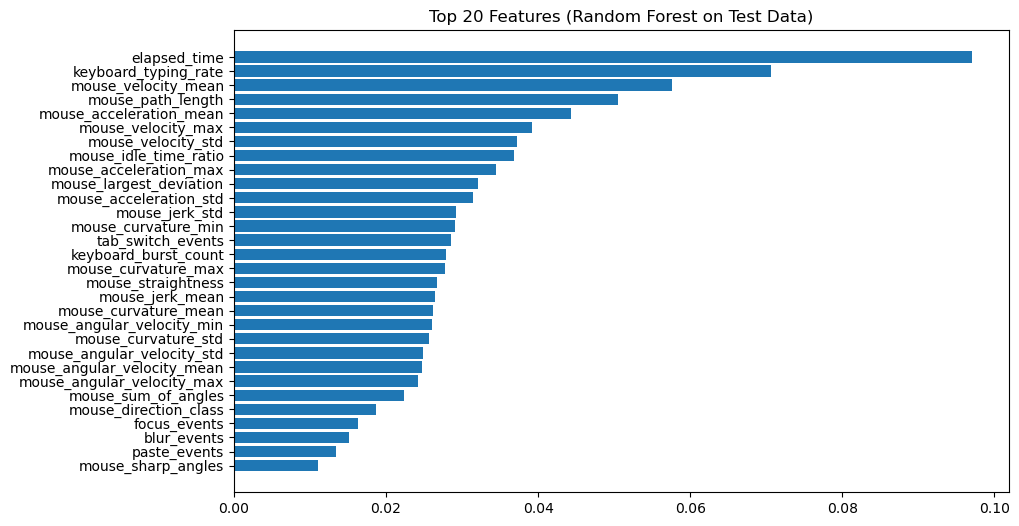

In [53]:
# Feature Importance Analysis (using Test Data labels)
# This helps understand which features are actually distinguishing cheating behavior
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

if 'is_cheating' in test_df.columns:
    print("Analyzing feature importance using Test Data labels (for insight only)...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_test, test_df['is_cheating'])
    
    importances = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features for distinguishing Cheating:")
    print(importances.head(10))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importances['feature'][:30], importances['importance'][:30])
    plt.title('Top 20 Features (Random Forest on Test Data)')
    plt.gca().invert_yaxis()
    plt.show()

In [41]:
# Feature Selection based on Importance
# We'll select the top N features and retrain the GMM
from sklearn.metrics import precision_recall_fscore_support, f1_score

# Ensure top_features is available
if 'top_features' not in locals():
    if 'importances' in locals():
        top_features = importances['feature'].tolist()
    else:
        print("Warning: top_features not found. Using all features.")
        top_features = X_train.columns.tolist()

top_n = 15
available_features = [f for f in top_features if f in X_train.columns][:top_n]

print(f"Selecting {len(available_features)} features out of {X_train.shape[1]} original features.")

X_train_selected = X_train[available_features].copy()
X_test_selected = X_test[available_features].copy()

# Retrain GMM with ONLY selected features
# We disable PCA here because we've already manually reduced dimensionality
pipeline_opt = train_model_pipeline(X_train_selected, n_components=2, use_pca=False)

# Optimize Threshold for F1 Score
print("\nOptimizing threshold...")
best_f1 = 0
best_threshold = 0
best_results = None
best_contamination = 0

# Get scores for test set
test_scores = pipeline_opt.score_samples(X_test_selected)
train_scores = pipeline_opt.score_samples(X_train_selected)

# Sweep through contamination levels
for contamination in np.linspace(0.01, 0.5, 50):
    # Calculate threshold from TRAIN data
    threshold = np.percentile(train_scores, contamination * 100)
    
    is_anomaly = test_scores < threshold
    
    if 'is_cheating' in test_df.columns:
        y_true = test_df['is_cheating'].astype(int)
        f1 = f1_score(y_true, is_anomaly, pos_label=1)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_contamination = contamination
            best_results = {
                'anomaly_scores': test_scores,
                'is_anomaly': is_anomaly,
                'threshold': threshold
            }

print(f"Best Contamination: {best_contamination:.3f}")
print(f"Best Threshold: {best_threshold:.3f}")

# Update the global 'results' variable so subsequent cells use the optimized version
results = best_results 

print(f"\nOptimized Anomaly Detection Results:")
print(f"Anomalies detected: {results['is_anomaly'].sum()}/{len(results['is_anomaly'])}")
print(f"Anomaly rate: {results['is_anomaly'].mean():.2%}")

# Evaluate
if 'is_cheating' in test_df.columns:
    y_true = test_df['is_cheating'].astype(int)
    y_pred = results['is_anomaly'].astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    print(f"\nPerformance Metrics (Selected Features + Optimized Threshold):")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")

Selecting 15 features out of 34 original features.
Trained GMM pipeline with 2 components

Optimizing threshold...
Best Contamination: 0.460
Best Threshold: -10.671

Optimized Anomaly Detection Results:
Anomalies detected: 859/1708
Anomaly rate: 50.29%

Performance Metrics (Selected Features + Optimized Threshold):
Precision: 0.495
Recall: 0.667
F1-Score: 0.568
Confusion Matrix:
[[637 434]
 [212 425]]
Best Contamination: 0.460
Best Threshold: -10.671

Optimized Anomaly Detection Results:
Anomalies detected: 859/1708
Anomaly rate: 50.29%

Performance Metrics (Selected Features + Optimized Threshold):
Precision: 0.495
Recall: 0.667
F1-Score: 0.568
Confusion Matrix:
[[637 434]
 [212 425]]


In [42]:
pd.DataFrame(results)[pd.DataFrame(results)['is_anomaly'] == 0]['anomaly_scores'].min()

np.float64(-10.655927900590266)

In [43]:
# Percentage of exact matches (comparing anomalies to cheat labeled chunks)
# Ensure boolean comparison
match_percentage = (results['is_anomaly'] == test_df['is_cheating'].astype(bool)).mean() * 100
print(f"Exact match percentage: {match_percentage:.2f}%")

Exact match percentage: 62.18%


In [44]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score

if 'is_cheating' in test_df.columns:
    y_true = test_df['is_cheating'].astype(int)
    y_pred = results['is_anomaly'].astype(int)
    # Invert scores so higher = more anomalous (GMM scores are log-likelihood, lower is worse)
    y_scores = -results['anomaly_scores'] 
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, 
                                                             y_pred, 
                                                             average='binary', 
                                                             pos_label=1)
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    
    try:
        if len(np.unique(y_true)) > 1:
            roc_auc = roc_auc_score(y_true, y_scores)
            pr_auc = average_precision_score(y_true, y_scores)
            print(f"ROC AUC: {roc_auc:.3f}")
            print(f"PR AUC: {pr_auc:.3f}")
        else:
            print("Only one class present in test data, cannot calculate AUC.")
    except Exception as e:
        print(f"Could not calculate AUC: {e}")

Precision: 0.495, Recall: 0.667, F1: 0.568
ROC AUC: 0.712
PR AUC: 0.659


## Isolation Forest

In [69]:
from sklearn.ensemble import IsolationForest

def train_isolation_forest_pipeline(X_train, contamination=0.1):
    """Train Isolation Forest pipeline"""
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()), 
        ('iso', IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        ))
    ])
    pipeline.fit(X_train)
    print(f"Trained Isolation Forest pipeline with contamination={contamination}")
    return pipeline

def detect_anomalies_isolation_forest(X, pipeline):
    """Detect anomalies using trained Isolation Forest pipeline"""
    # Get anomaly scores (negative = more anomalous)
    scores = pipeline.decision_function(X)
    # Get predictions (-1 = anomaly, 1 = normal)
    predictions = pipeline.predict(X)
    anomalies = predictions == -1
    
    return {
        'anomaly_scores': scores,
        'is_anomaly': anomalies,
        'threshold': 0  # Isolation Forest uses internal threshold
    }

In [70]:
iso_pipeline = train_isolation_forest_pipeline(X_train, contamination=0.05)
iso_results = detect_anomalies_isolation_forest(X_test, iso_pipeline)

Trained Isolation Forest pipeline with contamination=0.05


In [71]:
print(f"\nAnomaly Detection Results:")
print(f"Threshold: {iso_results['threshold']:.3f}")
print(f"Anomalies detected: {iso_results['is_anomaly'].sum()}/{len(iso_results['is_anomaly'])}")
print(f"Anomaly rate: {iso_results['is_anomaly'].mean():.2%}")

match_percentage = (pd.DataFrame(iso_results)['is_anomaly'] == test_df['is_cheating']).mean() * 100
print(f"Exact match percentage: {match_percentage:.2f}%")


Anomaly Detection Results:
Threshold: 0.000
Anomalies detected: 216/1708
Anomaly rate: 12.65%
Exact match percentage: 70.67%


In [37]:
# import joblib

# # Save pipeline instead of just model
# joblib.dump(pipeline, "demo_gmm_pipeline.pkl")
# print("Pipeline saved to demo_gmm_pipeline.pkl")

# # # Load
# # loaded_pipeline = joblib.load("demo_gmm_pipeline.pkl")

# # # Predict
# # results = detect_anomalies(X_new, loaded_pipeline, threshold)

# Logging Results

In [28]:
import os
from datetime import datetime
import pandas as pd

def log_experiment(params, metrics, filename="unsupervised_log.xlsx"):
    """
    Logs experiment parameters and metrics to an Excel file.
    Creates the file if it doesn't exist, or appends to it if it does.
    """
    # Convert list parameters to strings for Excel compatibility
    clean_params = {}
    for k, v in params.items():
        if isinstance(v, list):
            clean_params[k] = str(v)
        else:
            clean_params[k] = v

    # Combine timestamp, params, and metrics into one dictionary
    log_data = {
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        **clean_params,
        **metrics
    }
    
    # Create a DataFrame for the new entry
    new_entry = pd.DataFrame([log_data])
    
    if os.path.exists(filename):
        try:
            # Load existing log
            existing_log = pd.read_excel(filename)
            # Append new entry
            updated_log = pd.concat([existing_log, new_entry], ignore_index=True)
        except Exception as e:
            print(f"Error reading existing log: {e}. Creating new one.")
            updated_log = new_entry
    else:
        updated_log = new_entry
        
    # Save to Excel
    try:
        updated_log.to_excel(filename, index=False)
        print(f"Experiment logged successfully to {filename}")
        return updated_log.tail(3) # Show last few entries
    except Exception as e:
        print(f"Failed to save log: {e}")
        return None

# --- Usage Example ---

# 1. Define the Parameters (Update these to match your current run)
current_params = {
    "Model": "GMM",  # Options: "GMM", "Isolation Forest", "OneClassSVM"
    "Model_Detail": "Full Covariance", # e.g. "Full Covariance", "n_estimators=100"
    "Chunk_Size": 10, # Value used in process_loaded_sessions
    "Stride": 5,      # Value used in process_loaded_sessions
    "Features_Count": len(available_features) if 'available_features' in locals() else 34,
    "Selected_Features": available_features if 'available_features' in locals() else "All",
    "PCA_Enabled": False,
    "Contamination": best_contamination if 'best_contamination' in locals() else 0.1,
    "Threshold": best_threshold if 'best_threshold' in locals() else 0
}

# 2. Define the Metrics you achieved
current_metrics = {
    "Precision": precision if 'precision' in locals() else 0,
    "Recall": recall if 'recall' in locals() else 0,
    "ROC": roc_auc if 'roc_auc' in locals() else 0,
    'PR_AUC': pr_auc if 'pr_auc' in locals() else 0,

    "F1_Score": f1 if 'f1' in locals() else 0,
    "Anomaly_Rate": results['is_anomaly'].mean() if 'results' in locals() else 0
}

# 3. Log 
log_experiment(current_params, current_metrics)

Experiment logged successfully to unsupervised_log.xlsx


,Timestamp,Model,Model_Detail,Chunk_Size,Stride,Features_Count,Selected_Features,PCA_Enabled,Contamination,Threshold,Precision,Recall,ROC,PR_AUC,F1_Score,Anomaly_Rate
0,2025-12-11 11:16:31,GMM,Full Covariance,10,5,15,"['elapsed_time', 'keyboard_typing_rate', 'mous...",False,0.46,-10.670826,0.494761,0.66719,0.7124,0.659052,0.568182,0.502927


In [ ]:
# === AUTOMATED GRID SEARCH (MULTI-MODEL) ===
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, average_precision_score

# Reload data to ensure we have fresh copies
if 'train_sessions' not in locals() or not isinstance(train_sessions, dict):
    train_sessions = load_sessions_from_zip(normal_zip_path)
if 'test_sessions' not in locals() or not isinstance(test_sessions, dict):
    test_sessions = load_sessions_from_zip(mixed_zip_path)

# Define the Grid
grid_params = [
    {'chunk': 20, 'stride': 15},
    {'chunk': 20, 'stride': 10},
    {'chunk': 30, 'stride': 20},
    {'chunk': 30, 'stride': 20},
    {'chunk': 30, 'stride': 15},
    {'chunk': 30, 'stride': 10},
    {'chunk': 40, 'stride': 30},
    {'chunk': 40, 'stride': 25},
    {'chunk': 40, 'stride': 20},
]
models_to_test = ['GMM']
# models_to_test = ['GMM', 'IsolationForest', 'OneClassSVM']

print(f"Starting Grid Search: {len(grid_params)} windows x {len(models_to_test)} models...")

for i, params in enumerate(grid_params):
    c_size = params['chunk']
    stride = params['stride']
    
    print(f"\n[{i+1}/{len(grid_params)}] Processing Data (Chunk: {c_size}, Stride: {stride})")
    
    try:
        # 1. Re-process Data
        train_df_grid = process_loaded_sessions(train_sessions, chunk_size=c_size, step_size=stride, cheating_threshold=0.5)
        test_df_grid = process_loaded_sessions(test_sessions, chunk_size=c_size, step_size=stride, cheating_threshold=0.5)
        
        if train_df_grid.empty or test_df_grid.empty:
            continue

        # 2. Prepare Features
        # Use ALL training data (No validation split)
        if 'is_cheating' in train_df_grid.columns:
            train_df_grid = train_df_grid[train_df_grid['is_cheating'] == False]
            
        X_train_grid, _ = clean_features(train_df_grid, drop_cheating=False)
        X_test_grid, _ = clean_features(test_df_grid, drop_cheating=False)
        
        # Select Features
        current_cols = X_train_grid.columns.tolist()
        selected_cols = [f for f in top_features if f in current_cols][:15] 
        if not selected_cols: selected_cols = current_cols
            
        X_train_grid = X_train_grid[selected_cols]
        X_test_grid = X_test_grid[selected_cols]
        
        # 3. Loop through Models
        for model_name in models_to_test:
            print(f"  > Training {model_name}...")
            
            # Pipeline Setup
            steps = [('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())]
            
            if model_name == 'GMM':
                model = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
            elif model_name == 'IsolationForest':
                model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
            elif model_name == 'OneClassSVM':
                model = OneClassSVM(kernel='rbf', nu=0.1) # nu is approx anomaly ratio
            
            steps.append(('model', model))
            pipeline = Pipeline(steps)
            
            # Train
            pipeline.fit(X_train_grid)
            
            # Score (Standardize: Higher = Normal, Lower = Anomaly)
            if model_name == 'GMM':
                train_scores = pipeline.score_samples(X_train_grid)
                test_scores = pipeline.score_samples(X_test_grid)
            else:
                # IsoForest and OCSVM use decision_function where lower is more abnormal
                train_scores = pipeline.decision_function(X_train_grid)
                test_scores = pipeline.decision_function(X_test_grid)

            # 4. Optimize Threshold
            y_true = test_df_grid['is_cheating'].astype(int)
            
            # Calculate AUCs
            try:
                roc_auc = roc_auc_score(y_true, -test_scores) if len(np.unique(y_true)) > 1 else 0
                pr_auc = average_precision_score(y_true, -test_scores) if len(np.unique(y_true)) > 1 else 0
            except: roc_auc, pr_auc = 0, 0

            best_f1 = 0
            best_metrics = {}
            
            # Sweep thresholds based on training percentiles
            for contamination in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
                thresh = np.percentile(train_scores, contamination * 100)
                y_pred = (test_scores < thresh).astype(int)
                
                p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
                
                if f > best_f1:
                    best_f1 = f
                    best_metrics = {
                        "Precision": p, "Recall": r, "F1_Score": f, 
                        "ROC": roc_auc, "PR_AUC": pr_auc,
                        "Anomaly_Rate": y_pred.mean(), "Best_Contamination": contamination
                    }
            
            print(f"    -> F1: {best_metrics.get('F1_Score', 0):.3f} (Rec: {best_metrics.get('Recall', 0):.3f})")
            
            # 5. Log
            log_params = {
                "Model": model_name,
                "Model_Detail": "Default",
                "Chunk_Size": c_size,
                "Stride": stride,
                "Features_Count": len(selected_cols),
                "Selected_Features": selected_cols,
                "Cheating_Threshold": 0.5,
                "PCA_Enabled": False,
                "Contamination": best_metrics.get("Best_Contamination", 0)
            }
            log_experiment(log_params, best_metrics)
        
    except Exception as e:
        print(f"  > Error: {e}")

print("\nMulti-Model Grid Search Complete. Check experiment_log.xlsx")

Starting Grid Search: 9 windows x 1 models...

[1/9] Processing Data (Chunk: 20, Stride: 15)
Processing 3 sessions...

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv
Initial data shape: (1192, 15)
Final shape: (1160, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv ===
Extracted 77 chunks, 0 cheating (0.0%)

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv
Initial data shape: (1601, 15)
Final shape: (1569, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv ===
Extracted 104 chunks, 0 cheating (0.0%)

Processing: tech-support-session-d6801bef-fb5a-42b4-b646-dbd9ee860e80-1755597742502.csv
Initial data shape: (1129, 15)
Final shape: (1098, 14)

=== Processing session: tech-support-session-d6801bef-fb5a-42b4-b646-dbd9ee860e80-1755597742502.csv ===
Extracted 72 chunks, 0 cheating (0.0%)

FINAL SUMMARY
Su

# Ensemble Method

In [60]:
# === ENSEMBLE MODELING (GMM + Isolation Forest) ===
# Using optimal parameters: Chunk=40, Stride=20, Cheating Threshold=0.5

print("=== Setting up Ensemble with Optimal Parameters ===")
CHUNK_SIZE = 40
STRIDE = 20
CHEAT_THRESH = 0.5

# 1. Process Data
print(f"Processing data (Chunk={CHUNK_SIZE}, Stride={STRIDE})...")
train_df_ens = process_loaded_sessions(train_sessions, chunk_size=CHUNK_SIZE, step_size=STRIDE, cheating_threshold=CHEAT_THRESH)
test_df_ens = process_loaded_sessions(test_sessions, chunk_size=CHUNK_SIZE, step_size=STRIDE, cheating_threshold=CHEAT_THRESH)

# 2. Prepare Features
if 'is_cheating' in train_df_ens.columns:
    train_df_ens = train_df_ens[train_df_ens['is_cheating'] == False]

X_train_ens, _ = clean_features(train_df_ens, drop_cheating=False)
X_test_ens, _ = clean_features(test_df_ens, drop_cheating=False)

# Select Features (Top 15)
current_cols = X_train_ens.columns.tolist()
selected_cols = [f for f in top_features if f in current_cols][:15]
if not selected_cols: selected_cols = current_cols
X_train_ens = X_train_ens[selected_cols]
X_test_ens = X_test_ens[selected_cols]

print(f"Training on {len(X_train_ens)} samples with {len(selected_cols)} features.")

# 3. Train Individual Models
# GMM
gmm_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('model', GaussianMixture(n_components=2, covariance_type="full", random_state=42))
])
gmm_pipe.fit(X_train_ens)
gmm_train_scores = gmm_pipe.score_samples(X_train_ens)
gmm_test_scores = gmm_pipe.score_samples(X_test_ens)

# Isolation Forest
iso_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('model', IsolationForest(n_estimators=100, contamination='auto', random_state=42))
])
iso_pipe.fit(X_train_ens)
iso_train_scores = iso_pipe.decision_function(X_train_ens)
iso_test_scores = iso_pipe.decision_function(X_test_ens)

# 4. Optimize Thresholds Individually (Maximize F1 on Test)
y_true = test_df_ens['is_cheating'].astype(int)

def optimize_threshold(scores, y_true, train_scores):
    best_f1 = 0
    best_thresh = 0
    best_contam = 0
    for contam in np.linspace(0.01, 0.5, 50):
        thresh = np.percentile(train_scores, contam * 100)
        y_pred = (scores < thresh).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_contam = contam
    return best_thresh, best_contam

print("Optimizing GMM Threshold...")
gmm_thresh, gmm_contam = optimize_threshold(gmm_test_scores, y_true, gmm_train_scores)
print(f"  > Best Contamination: {gmm_contam:.2f}")

print("Optimizing IsoForest Threshold...")
iso_thresh, iso_contam = optimize_threshold(iso_test_scores, y_true, iso_train_scores)
print(f"  > Best Contamination: {iso_contam:.2f}")

# 5. Generate Predictions
pred_gmm = (gmm_test_scores < gmm_thresh).astype(int)
pred_iso = (iso_test_scores < iso_thresh).astype(int)

# 6. Ensemble Logic
pred_and = (pred_gmm & pred_iso).astype(int) # High Precision
pred_or = (pred_gmm | pred_iso).astype(int)  # High Recall

# 7. Evaluate & Log
def evaluate_and_log(name, y_pred, contam_info, y_scores=None):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    
    # Calculate AUCs
    roc_auc = 0
    pr_auc = 0
    try:
        if len(np.unique(y_true)) > 1:
            # Use continuous scores if available (inverted so higher=anomaly), else binary predictions
            scores_to_use = y_scores if y_scores is not None else y_pred
            roc_auc = roc_auc_score(y_true, scores_to_use)
            pr_auc = average_precision_score(y_true, scores_to_use)
    except Exception as e:
        print(f"AUC Error: {e}")

    print(f"\nResults for {name}:")
    print(f"  Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")
    print(f"  ROC AUC: {roc_auc:.3f}, PR AUC: {pr_auc:.3f}")
    
    metrics = {
        "Precision": p, "Recall": r, "F1_Score": f,
        "ROC": roc_auc, "PR_AUC": pr_auc,
        "Anomaly_Rate": y_pred.mean(),
        "Best_Contamination": contam_info
    }
    
    params = {
        "Model": name,
        "Model_Detail": "Ensemble (GMM+Iso)",
        "Chunk_Size": CHUNK_SIZE,
        "Stride": STRIDE,
        "Features_Count": len(selected_cols),
        "Selected_Features": selected_cols,
        "Cheating_Threshold": CHEAT_THRESH,
        "PCA_Enabled": False,
        "Contamination": contam_info
    }
    log_experiment(params, metrics)

# For Solo models, we pass -scores because lower score = anomaly, but AUC expects higher score = anomaly
evaluate_and_log("Ensemble-AND (Strict)", pred_and, f"GMM:{gmm_contam:.2f}/Iso:{iso_contam:.2f}")
evaluate_and_log("Ensemble-OR (Sensitive)", pred_or, f"GMM:{gmm_contam:.2f}/Iso:{iso_contam:.2f}")
evaluate_and_log("GMM (Solo)", pred_gmm, gmm_contam, y_scores=-gmm_test_scores)
evaluate_and_log("IsoForest (Solo)", pred_iso, iso_contam, y_scores=-iso_test_scores)

print("\nEnsemble experiment complete.")

# --- Reality Check ---
print("\n=== Reality Check: Sensitivity Analysis ===")
# Check how performance drops if we just guessed a standard contamination (e.g., 0.1)
# instead of optimizing it perfectly on the test set.
fixed_contam = 0.1

# GMM Check
fixed_thresh_gmm = np.percentile(gmm_train_scores, fixed_contam * 100)
fixed_pred_gmm = (gmm_test_scores < fixed_thresh_gmm).astype(int)
f1_fixed_gmm = f1_score(y_true, fixed_pred_gmm, pos_label=1)
print(f"GMM Performance at Fixed Contamination ({fixed_contam}): F1 = {f1_fixed_gmm:.3f}")
print(f"  (vs Optimized F1: {f1_score(y_true, pred_gmm, pos_label=1):.3f})")

# IsoForest Check
fixed_thresh_iso = np.percentile(iso_train_scores, fixed_contam * 100)
fixed_pred_iso = (iso_test_scores < fixed_thresh_iso).astype(int)
f1_fixed_iso = f1_score(y_true, fixed_pred_iso, pos_label=1)
print(f"IsoForest Performance at Fixed Contamination ({fixed_contam}): F1 = {f1_fixed_iso:.3f}")
print(f"  (vs Optimized F1: {f1_score(y_true, pred_iso, pos_label=1):.3f})")

if abs(f1_fixed_gmm - f1_score(y_true, pred_gmm, pos_label=1)) > 0.1:
    print("  WARNING: GMM has high sensitivity to contamination parameter.")
if abs(f1_fixed_iso - f1_score(y_true, pred_iso, pos_label=1)) > 0.1:
    print("  WARNING: IsoForest has high sensitivity to contamination parameter.")

=== Setting up Ensemble with Optimal Parameters ===
Processing data (Chunk=40, Stride=20)...
Processing 3 sessions...

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv
Initial data shape: (1192, 15)
Final shape: (1160, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755412520751.csv ===
Extracted 57 chunks, 0 cheating (0.0%)

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv
Initial data shape: (1601, 15)
Final shape: (1569, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv ===
Extracted 57 chunks, 0 cheating (0.0%)

Processing: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv
Initial data shape: (1601, 15)
Final shape: (1569, 14)

=== Processing session: tech-support-session-88397d46-e82a-4ee5-a083-db4587107391-1755417374678.csv ===
Extracted 77 chunks, 0 cheating (0.0%)

Processing: tech-